# Question 110 - Customer frequency -- a multi-question problem
Data Analysis Python Pandas Data Manipulation Data Visualization Histogram External Dataset

Given the following [dataset](https://drive.google.com/file/d/1vvnaJ9KErXx2zI47IBytR_tHGijtJBE6/view), 
classify customer value based on order frequency. You can assign them a score of 1-3, with 1 being least valuable and 3 being most valuable For example, a customer who has made 10 purchases is more valuable than one that has made 2 purchases across the same time period.

For more information regarding customer lifetime value you can read [this post](https://www.shopify.com/blog/customer-lifetime-value).

The solution will be written in Python for premium users. Note that this question is a part of a series of questions that will build off of each other.

See also question 107.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as spstats
import seaborn as sns

raw_df = pd.read_csv(
    'q110_data.csv', 
#     encoding='ISO-8859-1', 
    parse_dates=['InvoiceDate']
)
raw_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
# same approach as question 107
# clean up and build main dataset
raw_df['dt'] = raw_df['InvoiceDate'].dt.date
raw_df['spend'] = raw_df['Quantity'] * raw_df['UnitPrice']
daily_user_spend_df = (
    raw_df
    .dropna()
    .query('spend>0')
    .groupby(['CustomerID','dt'])
    .agg({'spend':'sum'})
    .reset_index()
    .rename({'CustomerID':'cid'},axis='columns')
)
daily_user_spend_df['cid'] = daily_user_spend_df['cid'].astype('int64')
daily_user_spend_df.head()


,cid,dt,spend
0,12346,2011-01-18,77183.60
1,12347,2010-12-07,711.79
2,12348,2010-12-16,892.80
3,12356,2011-01-18,2271.62
4,12359,2011-01-12,547.50


In [3]:
start_dt, end_dt = daily_user_spend_df['dt'].min(), daily_user_spend_df['dt'].max()
print(f'Timeframe is {start_dt} to {end_dt}')

Timeframe is 2010-12-01 to 2011-01-20


In [4]:
# timeframe = [start_dt, end_dt]
start_dt, end_dt = daily_user_spend_df['dt'].min(), daily_user_spend_df['dt'].max()
span_days = (end_dt - start_dt).days # https://stackoverflow.com/a/45039811

# rec: recency in [0,1]. 0 means last seen on end_dt, 1 last seen on start_dt. 
# freq: frequency in [0,1]. number of days seen during period / period length
# spend: total spend over whole period
rfm_users_df = daily_user_spend_df.groupby('cid').agg({'dt':['max','count'],'spend':'sum'})
rfm_users_df.columns = ['last_dt','freq_days','spend'] # change column names
# could use ["_".join(x) for x in df.columns.ravel()] instead
rfm_users_df['freq_norm'] = rfm_users_df['freq_days'] / span_days # in (0,1], 0 is rare
# could divide freq by customer lifespan instead
rfm_users_df['rec'] = (end_dt - rfm_users_df['last_dt']).dt.days / (span_days+1) # in [0,1), 0 is recent
# span_days+1 so a user who showed up only on 2010-12-01 scores <1
rfm_users_df.drop(['last_dt'], axis='columns', inplace=True)
rfm_users_df.head()


,freq_days,spend,freq_norm,rec
cid,,,,
12346,1,77183.60,0.02,0.039216
12347,1,711.79,0.02,0.862745
12348,1,892.80,0.02,0.686275
12356,1,2271.62,0.02,0.039216
12359,1,547.50,0.02,0.156863


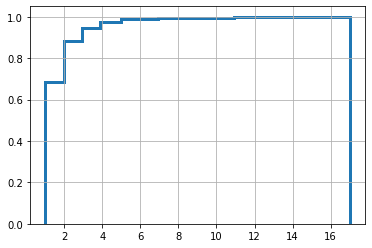

In [5]:
# option 1: frequency_score = quantile.
# won't work because 33 percentile and 66th percentile are equal
h = rfm_users_df['freq_days'].hist(cumulative=True, density=1, bins=100, histtype='step', linewidth=3) # x=freq, y=cdf
# rfm_users_df['freq_score_1'] = pd.qcut(rfm_users_df['freq'],3,labels=[1,2,3]) # 3 means frequent
# rfm_users_df['freq_score_1'].hist()

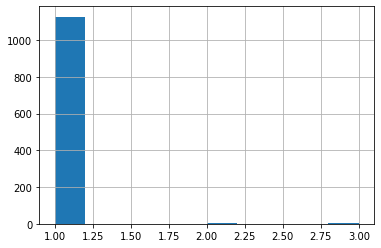

In [6]:
# option 2: rank of bin, when binning into 3 even segments of frequency
# kind of meh: the graph above shows no one will be in the most-recent bucket 
rfm_users_df['freq_score_2'] = pd.cut(rfm_users_df['freq_days'],3,labels=[1,2,3]) # 3 means recent
rfm_users_df['freq_score_2'].hist()

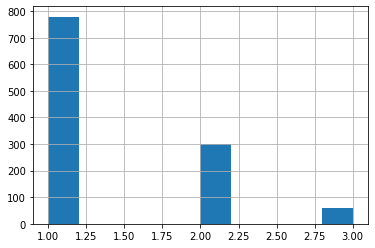

In [7]:
# option 3: custom formula based on CDF
# purchased once = 1,
# purchased 2-3 times = 2,
# purchased 4+ times = 3

rule_set = {
    1: (rfm_users_df['freq_days'] == 1),
    2: (rfm_users_df['freq_days'] >= 2) & (rfm_users_df['freq_days'] <= 3),
    3: (rfm_users_df['freq_days'] >= 4),
}
rfm_users_df['freq_score_3'] = np.select(
    list(rule_set.values()), 
    list(rule_set.keys()),
    default=1
)

rfm_users_df['freq_score_3'].hist()


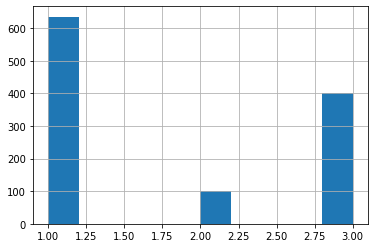

In [8]:
# add recency score
# option 3: recency_score = round( 3 * (2^(1-rec)-1) ). 
# rationale: 1-rec so 0 means ancient, 1 means recent
# 2^x-1 makes a 1-day difference between recencies of 1d and 2d bigger, 
# and between 90d and 91d negligible.
# 2^x-1 is valid because it's a bijection from [0,1] to [0,1]
rfm_users_df['rec_score_3'] = np.ceil(3* (2**(1-rfm_users_df['rec'])-1)).astype(int)
rfm_users_df['rec_score_3'].hist()


In [9]:
pd.crosstab(rfm_users_df['rec_score_3'],rfm_users_df['freq_score_3'])
# there are 54 high-recency and high-frequency customers!

freq_score_3,1,2,3
rec_score_3,,,
1,525,107,3
2,53,45,4
3,201,147,54
